In [ ]:
import pandas as pd

kepco_path = 'kepcoTotal_preprocessed.csv'
detotal_path = 'deTotal_preprocessed.csv'

kepco_data = pd.read_csv(kepco_path)
detotal_data = pd.read_csv(detotal_path)

In [ ]:
from tensorflow.keras.models import load_model

kepco_model_path = 'kr_weight.h5'
detotal_model_path = 'de_weight.h5'

kepco_model = load_model(kepco_model_path)
detotal_model = load_model(detotal_model_path)
kepco_model.summary(), detotal_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 24, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30651 (239.46 KB)
Trainable params: 30651 (239.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential

(None, None)

In [ ]:
import numpy as np
def create_sequences(data, sequence_length=24):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)

sequence_length = 24
kepco_sequences = create_sequences(kepco_data['Hourly Sum'].values, sequence_length)
detotal_sequences = create_sequences(detotal_data['Hourly Sum'].values, sequence_length)

kepco_predicted = kepco_model.predict(kepco_sequences)
detotal_predicted = detotal_model.predict(detotal_sequences)

kepco_real = kepco_data['Hourly Sum'].values[sequence_length:]
detotal_real = detotal_data['Hourly Sum'].values[sequence_length:]

kepco_error_rate = abs(kepco_real - kepco_predicted.flatten()) / kepco_real
detotal_error_rate = abs(detotal_real-detotal_predicted.flatten()) / detotal_real

kepco_threshold = np.percentile(kepco_error_rate, 10)
detotal_threshold = np.percentile(detotal_error_rate, 10)

kepco_filtered = kepco_data.iloc[sequence_length:][kepco_error_rate > kepco_threshold]
detotal_filtered = detotal_data.iloc[sequence_length:][detotal_error_rate > detotal_threshold]

kepco_filtered.to_csv('kepco_filtered.csv', index=False)
detotal_filtered.to_csv('detotal_filtered.csv', index=False)

2146/2146 [==============================] - 47s 21ms/step


1755/1755 [==============================] - 37s 21ms/step


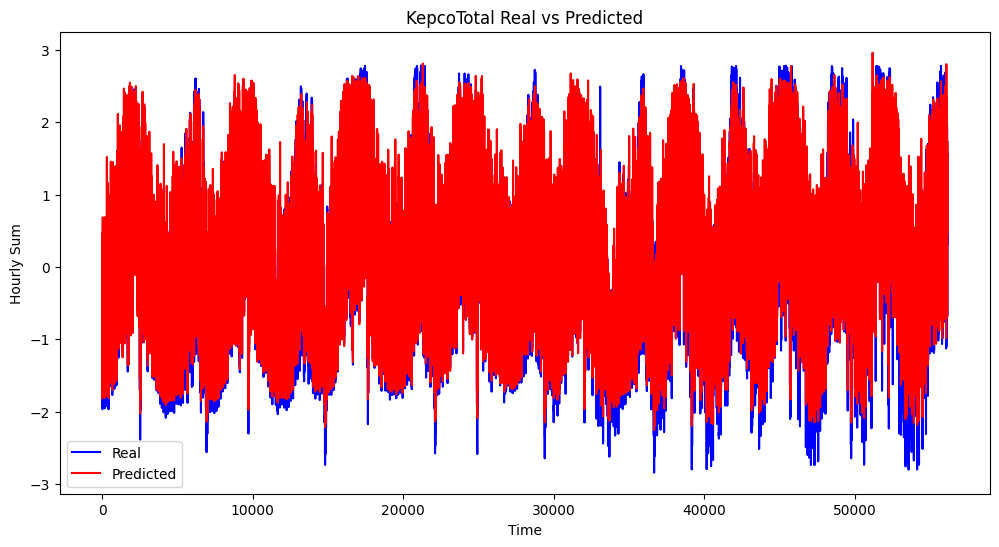

1930/1930 [==============================] - 41s 21ms/step


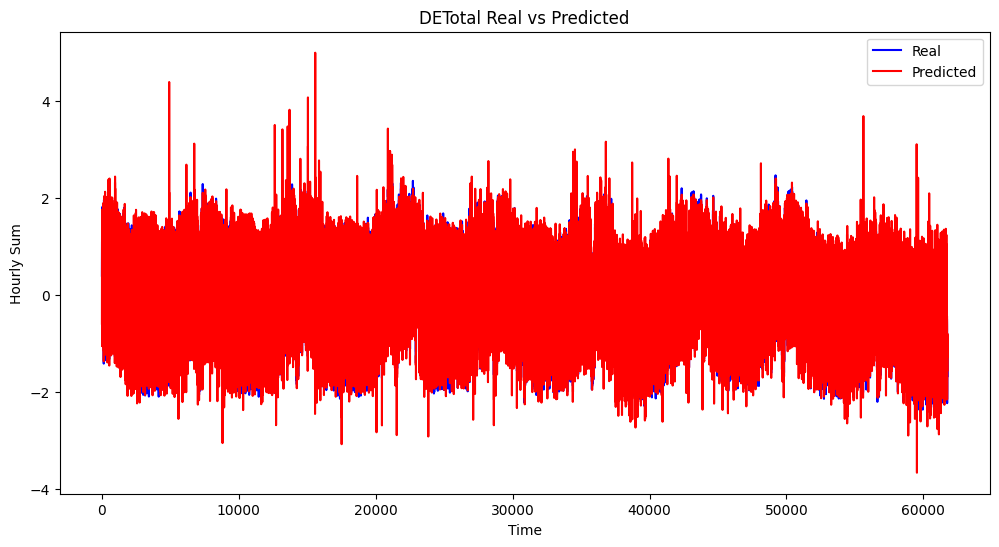

In [ ]:
import matplotlib.pyplot as plt

# kepcoTotal data 그래프 (Ground truth v/s predicted value)
kepco_filtered_sequences = create_sequences(kepco_filtered['Hourly Sum'].values, sequence_length)
kepco_filtered_predicted = kepco_model.predict(kepco_filtered_sequences)
kepco_filtered_real = kepco_filtered['Hourly Sum'].values[sequence_length:]

plt.figure(figsize=(12, 6))
plt.plot(kepco_filtered_real, label='Real', color='blue')
plt.plot(kepco_filtered_predicted.flatten(), label='Predicted', color='red')
plt.title('KepcoTotal Real vs Predicted')
plt.xlabel('Time')
plt.ylabel('Hourly Sum')
plt.legend()
plt.show()

# deTotal data 그래프 (Ground truth v/s predicted value)
detotal_filtered_sequences = create_sequences(detotal_filtered['Hourly Sum'].values, sequence_length)
detotal_filtered_predicted = detotal_model.predict(detotal_filtered_sequences)
detotal_filtered_real = detotal_filtered['Hourly Sum'].values[sequence_length:]

plt.figure(figsize=(12, 6))
plt.plot(detotal_filtered_real, label='Real', color='blue')
plt.plot(detotal_filtered_predicted.flatten(), label='Predicted', color='red')
plt.title('DETotal Real vs Predicted')
plt.xlabel('Time')
plt.ylabel('Hourly Sum')
plt.legend()
plt.show()

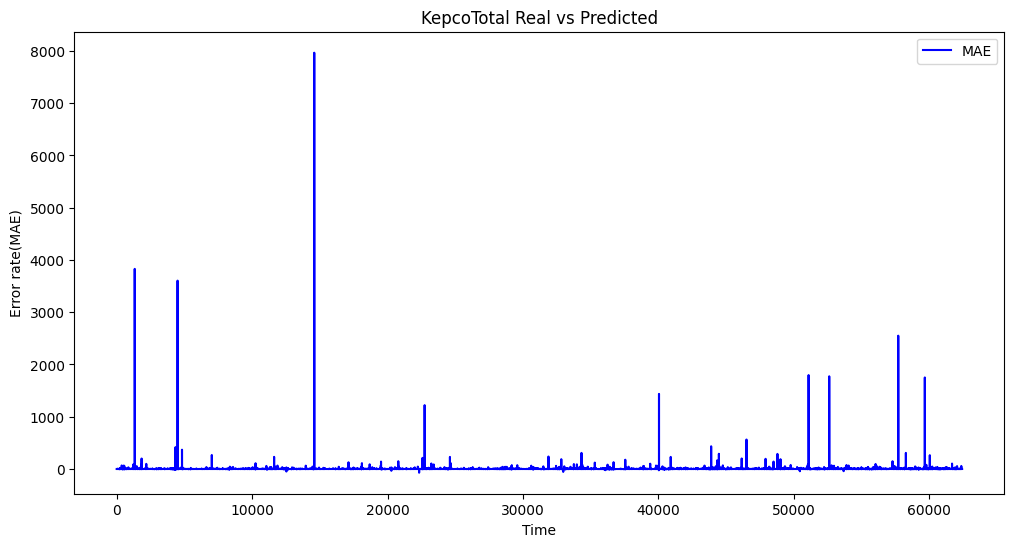

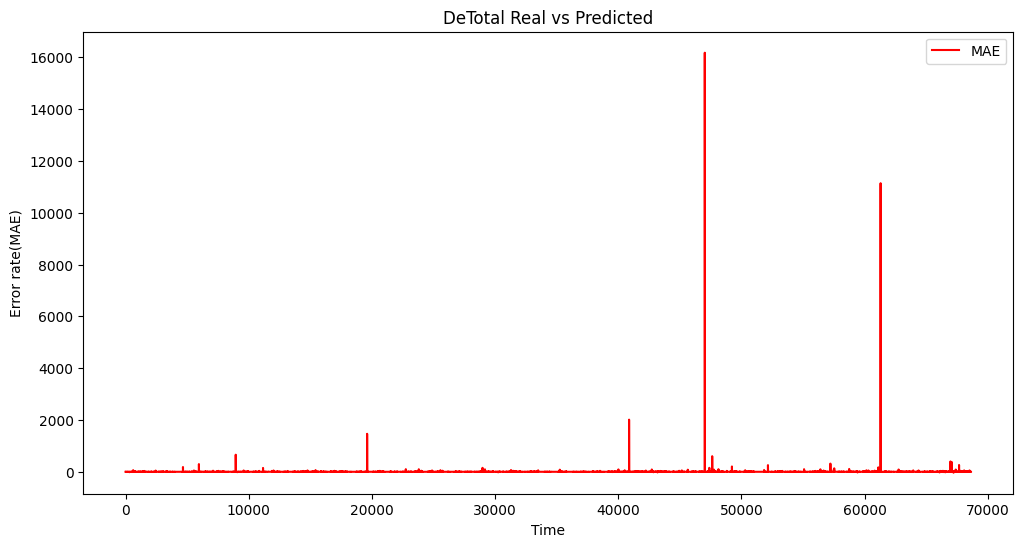

In [ ]:
# kepcoTotal data 오차율 그래프
plt.figure(figsize=(12, 6))
plt.plot(kepco_error_rate, label='MAE', color='blue')
plt.title('KepcoTotal Real vs Predicted')
plt.xlabel('Time')
plt.ylabel('Error rate(MAE)')
plt.legend()
plt.show()

# deTotal data 오차율 그래프
plt.figure(figsize=(12, 6))
plt.plot(detotal_error_rate, label='MAE', color='red')
plt.title('DeTotal Real vs Predicted')
plt.xlabel('Time')
plt.ylabel('Error rate(MAE)')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error

mae_per_point1 = [mean_absolute_error([real], [pred]) for real, pred in zip(kepco_filtered_real, kepco_filtered_predicted.flatten())]
m_mmae = np.mean(mae_per_point1)

print("mMAE for Kepco:", m_mmae)

mae_per_point2 = [mean_absolute_error([real], [pred]) for real, pred in zip(detotal_filtered_real, detotal_filtered_predicted.flatten())]
m_mmae = np.mean(mae_per_point2)

print("mMAE for DE:", m_mmae)

mMAE for Kepco: 0.2332430042030549
mMAE for DE: 0.17727575228443476
